In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q torchinfo

In [ ]:
import os
import random
import numpy as np
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensures deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)

Random seed set to 42


In [ ]:
DATA_ROOT = Path("drive/MyDrive/datasets")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = max(1, (os.cpu_count() or 1) // 2)

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def create_dataloaders(data_root: Path,
                       batch_size: int = BATCH_SIZE,
                       img_size: int = IMG_SIZE,
                       num_workers: int = NUM_WORKERS):
    """Create ImageFolder datasets with augmentation-aware dataloaders."""
    data_root = Path(data_root)
    if not data_root.exists():
        raise FileNotFoundError(f"Dataset root not found: {data_root.resolve()}")

    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomAffine(degrees=20, scale=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    datasets_map = {
        "train": datasets.ImageFolder(root=data_root / "train", transform=train_transforms),
        "val": datasets.ImageFolder(root=data_root / "val", transform=eval_transforms),
    }

    dataloaders = {
        split: DataLoader(ds,
                          batch_size=batch_size,
                          shuffle=(split == "train"),
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available())
        for split, ds in datasets_map.items()
    }

    return dataloaders, datasets_map["train"].classes


dataloaders, class_names = create_dataloaders(DATA_ROOT)

for split, loader in dataloaders.items():
    print(f"{split}: {len(loader.dataset)} images across {len(class_names)} classes")

print(f"Classes: {class_names}")

train: 20000 images across 2 classes
val: 5000 images across 2 classes
Classes: ['cat', 'dog']


Random seed set to 42


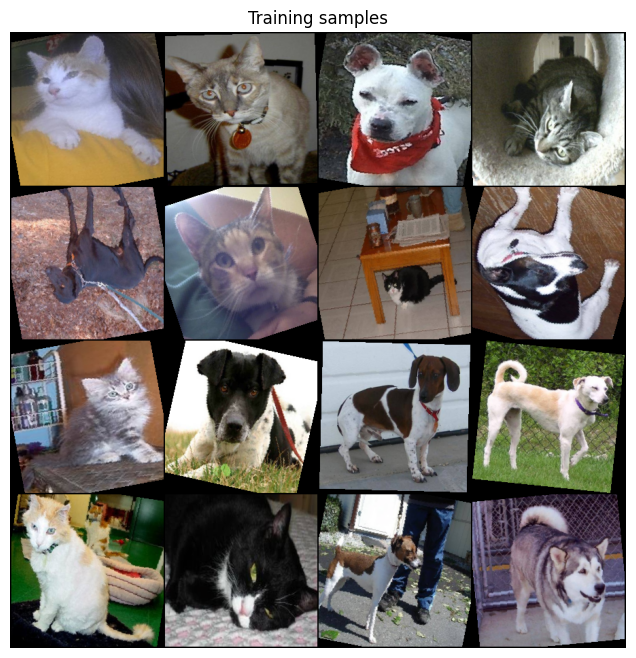

In [ ]:
def visualize_batch(dataloader, n_images: int = 16, title: Optional[str] = None):
    """Display a grid of images from a dataloader batch."""
    if n_images < 1:
        raise ValueError("n_images must be at least 1")

    images, labels = next(iter(dataloader))
    n_images = min(n_images, images.size(0))
    images = images[:n_images].detach().cpu()

    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    images = images * std + mean

    grid = make_grid(images, nrow=int(n_images**0.5) or 1, padding=2)
    np_img = grid.permute(1, 2, 0).numpy().clip(0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title or "Sample batch")
    plt.show()

set_seed(42)
visualize_batch(dataloaders["train"], title="Training samples")

In [ ]:
import torch
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, num_classes=2):
        super(TinyVGG, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 112x112
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 56x56
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 28x28
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 14x14
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]

model = TinyVGG(num_classes=2).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

device

device(type='cuda')

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         448
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 16, 224, 224]         2,320
│    └─ReLU: 2-4                         [1, 16, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 16, 112, 112]         --
├─Sequential: 1-2                        [1, 32, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 32, 112, 112]         4,640
│    └─ReLU: 2-7                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 32, 112, 112]         9,248
│    └─ReLU: 2-9                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 32, 56, 56]           --
├─Seq

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader,
                              desc=f"Train [{epoch + 1}/{num_epochs}]",
                              leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}", end="")

    return train_loss, train_acc

In [ ]:
def evaluate(model, val_loader, criterion, device, epoch, num_epochs):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader,
                              desc=f" Validation [{epoch + 1}/{num_epochs}]",
                              leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, './drive/MyDrive/dl/TinyVGG-weights.pth')
        print(f"Saved new best model at epoch {epoch+1} (Val Acc: {val_acc:.4f})")

    return val_loss, val_acc

In [ ]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_acc = 0.0
best_val_loss = float('inf')
num_epochs = 30
patience = 5

set_seed(42)

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch, num_epochs)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        print(f"[INFO] No improvement ({counter}/{patience})")
        if counter >= patience:
            print("[INFO] Early stopping triggered")
            break

Random seed set to 42


Epoch [1/30] | Train Loss: 0.6787 | Train Acc: 0.5807

  Val Loss: 0.6255 | Val Acc: 0.6590
Saved new best model at epoch 1 (Val Acc: 0.6590)


Epoch [2/30] | Train Loss: 0.6187 | Train Acc: 0.6693

  Val Loss: 0.5857 | Val Acc: 0.6998
Saved new best model at epoch 2 (Val Acc: 0.6998)


Epoch [3/30] | Train Loss: 0.5679 | Train Acc: 0.7130

  Val Loss: 0.5198 | Val Acc: 0.7498
Saved new best model at epoch 3 (Val Acc: 0.7498)


Epoch [4/30] | Train Loss: 0.5246 | Train Acc: 0.7433

  Val Loss: 0.4979 | Val Acc: 0.7644
Saved new best model at epoch 4 (Val Acc: 0.7644)


Epoch [5/30] | Train Loss: 0.4856 | Train Acc: 0.7732

  Val Loss: 0.4403 | Val Acc: 0.7966
Saved new best model at epoch 5 (Val Acc: 0.7966)


Epoch [6/30] | Train Loss: 0.4555 | Train Acc: 0.7903

  Val Loss: 0.4387 | Val Acc: 0.7948
Saved new best model at epoch 6 (Val Acc: 0.7948)


Epoch [7/30] | Train Loss: 0.4271 | Train Acc: 0.8050

  Val Loss: 0.4153 | Val Acc: 0.8118
Saved new best model at epoch 7 (Val Acc: 0.8118)


Epoch [8/30] | Train Loss: 0.4018 | Train Acc: 0.8225

  Val Loss: 0.3681 | Val Acc: 0.8414
Saved new best model at epoch 8 (Val Acc: 0.8414)


Epoch [9/30] | Train Loss: 0.3703 | Train Acc: 0.8371

  Val Loss: 0.3113 | Val Acc: 0.8686
Saved new best model at epoch 9 (Val Acc: 0.8686)


Epoch [10/30] | Train Loss: 0.3547 | Train Acc: 0.8451

  Val Loss: 0.2937 | Val Acc: 0.8722
Saved new best model at epoch 10 (Val Acc: 0.8722)


Epoch [11/30] | Train Loss: 0.3325 | Train Acc: 0.8578

  Val Loss: 0.4085 | Val Acc: 0.7966
Saved new best model at epoch 11 (Val Acc: 0.7966)
[INFO] No improvement (1/5)


Epoch [12/30] | Train Loss: 0.3193 | Train Acc: 0.8607

  Val Loss: 0.2460 | Val Acc: 0.8916
Saved new best model at epoch 12 (Val Acc: 0.8916)


Epoch [13/30] | Train Loss: 0.3054 | Train Acc: 0.8693

  Val Loss: 0.2606 | Val Acc: 0.8840
Saved new best model at epoch 13 (Val Acc: 0.8840)
[INFO] No improvement (1/5)


Epoch [14/30] | Train Loss: 0.2893 | Train Acc: 0.8766

  Val Loss: 0.2294 | Val Acc: 0.9014
Saved new best model at epoch 14 (Val Acc: 0.9014)


Epoch [15/30] | Train Loss: 0.2744 | Train Acc: 0.8842

  Val Loss: 0.2316 | Val Acc: 0.8992
Saved new best model at epoch 15 (Val Acc: 0.8992)
[INFO] No improvement (1/5)


Epoch [16/30] | Train Loss: 0.2772 | Train Acc: 0.8787

  Val Loss: 0.2115 | Val Acc: 0.9042
Saved new best model at epoch 16 (Val Acc: 0.9042)


Epoch [17/30] | Train Loss: 0.2556 | Train Acc: 0.8934

  Val Loss: 0.2035 | Val Acc: 0.9160
Saved new best model at epoch 17 (Val Acc: 0.9160)


Epoch [18/30] | Train Loss: 0.2542 | Train Acc: 0.8959

  Val Loss: 0.2002 | Val Acc: 0.9082
Saved new best model at epoch 18 (Val Acc: 0.9082)


Epoch [19/30] | Train Loss: 0.2441 | Train Acc: 0.8963

  Val Loss: 0.1815 | Val Acc: 0.9232
Saved new best model at epoch 19 (Val Acc: 0.9232)


Epoch [20/30] | Train Loss: 0.2434 | Train Acc: 0.8977

  Val Loss: 0.1999 | Val Acc: 0.9106
Saved new best model at epoch 20 (Val Acc: 0.9106)
[INFO] No improvement (1/5)


Epoch [21/30] | Train Loss: 0.2362 | Train Acc: 0.9007

  Val Loss: 0.1827 | Val Acc: 0.9260
Saved new best model at epoch 21 (Val Acc: 0.9260)
[INFO] No improvement (2/5)


Epoch [22/30] | Train Loss: 0.2308 | Train Acc: 0.9047

  Val Loss: 0.1971 | Val Acc: 0.9172
Saved new best model at epoch 22 (Val Acc: 0.9172)
[INFO] No improvement (3/5)


Epoch [23/30] | Train Loss: 0.2271 | Train Acc: 0.9046

  Val Loss: 0.1939 | Val Acc: 0.9168
Saved new best model at epoch 23 (Val Acc: 0.9168)
[INFO] No improvement (4/5)


Epoch [24/30] | Train Loss: 0.2243 | Train Acc: 0.9085

  Val Loss: 0.1791 | Val Acc: 0.9220
Saved new best model at epoch 24 (Val Acc: 0.9220)


KeyboardInterrupt: 

In [ ]:
import re
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(16, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss', marker='o')
    plt.plot(range(len(history['val_loss'])), history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(len(history['train_acc'])), history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(range(len(history['val_acc'])), history['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

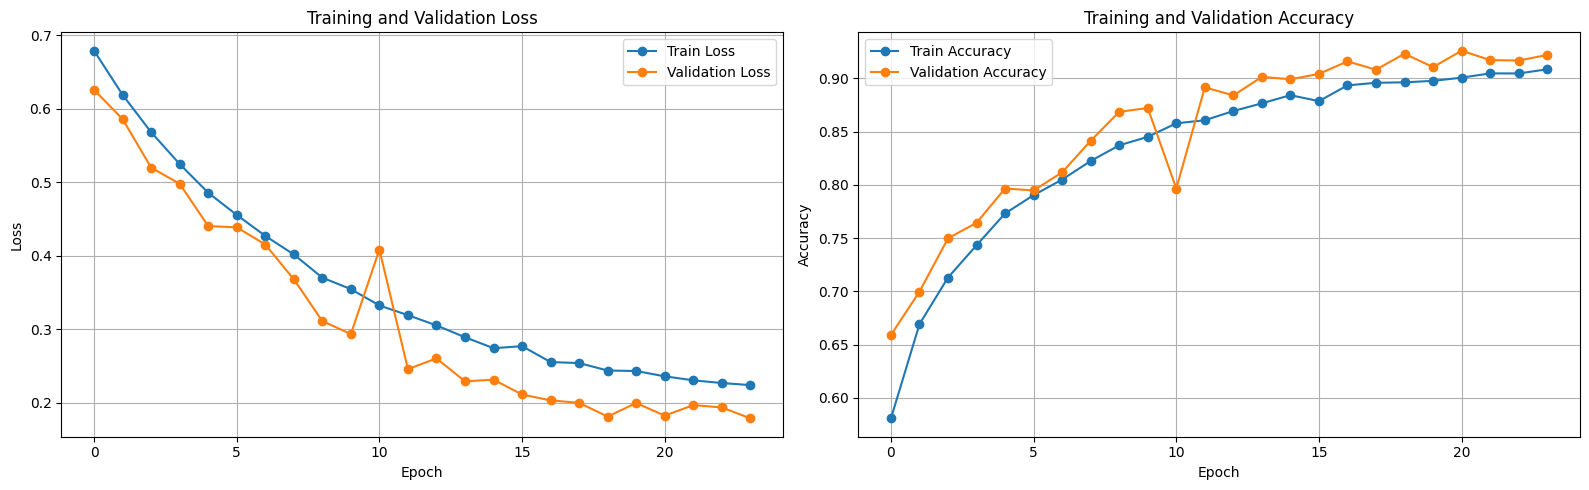

In [ ]:
plot_training_history(history)

In [ ]:
def get_misclassified_samples(model, dataloader, device=None, max_samples=None):

    model.eval()
    if device is None:
        device = next(model.parameters()).device

    misclassified = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            inputs, labels = batch
            indices = [None] * len(inputs)

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            mismatches = preds != labels
            for i in torch.where(mismatches)[0]:
                sample = {
                    'input': inputs[i].cpu(),
                    'true_label': labels[i].item(),
                    'pred_label': preds[i].item(),
                    'index': indices[i],
                }
                misclassified.append(sample)

                if max_samples and len(misclassified) >= max_samples:
                    return misclassified

    return misclassified

In [ ]:
checkpoint = torch.load('./drive/MyDrive/dl/TinyVGG-val-0.9220.pth', map_location='cpu')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
misclassified = get_misclassified_samples(model, val_loader, device='cuda', max_samples=10)

In [ ]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img_tensor):
    """
    Denormalize an image tensor that was normalized using ImageNet statistics.
    Input: img_tensor (C, H, W), normalized
    Output: img_tensor (C, H, W), values in [0, 1]
    """
    img_tensor = img_tensor * IMAGENET_STD + IMAGENET_MEAN
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return img_tensor

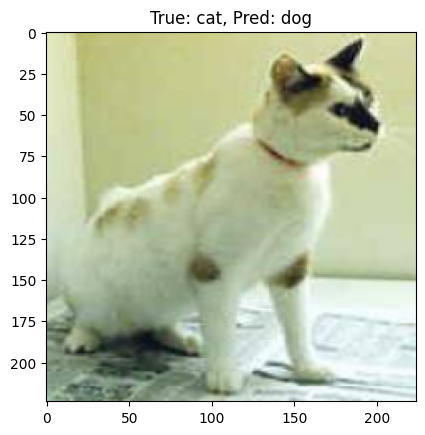

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

sample = misclassified[7]
img = F.to_pil_image(denormalize(sample['input']))
plt.imshow(img)
plt.title(f"True: {class_names[sample['true_label']]}, Pred: {class_names[sample['pred_label']]}")
plt.show()